<center>
<h2>Named Entity recognition using B I O Labeling in NLP</h2>
<img src="https://miro.medium.com/max/700/0*NoDvGqvXTfaDoGmg"/>
<br>
</center>

<div style="color:#FFFFFF; background:#34b1eb; border-radius:5px;"> 
    <center><br> <h1>Introduction</h1> <br></center>
</div>

I found a very nice <a href="https://link.springer.com/content/pdf/10.1007%2F978-3-030-50417-5_23.pdf">paper</a> where the authors are doing something very similar to what this competition is asking for. It seemed a very good starting point to me.

To summarize their approach :

1. **Create BIO (B:Begin, I:Inside, and O:Outside) labeling for your dataset**, for eg- label this sentence ["We", "are", "using", "COVID", "19", "Dataset", "in", "our", "paper"] as ["O", "O", "O", "B", "I", "I", "O", "O", "O"]. Here, B is first word of a dataset, I is word that is a part of a dataset and O is any other word in our dataset.

2. **Experiment with various word to vector conversion algorithms (word embedding algorithms)**, for eg - Word2Vec, Bag of Words etc.

3. **Train Bi-directional LSTM to predict BIO labels for a given sentence**.

4. It may output sequences (e.g., “OIO”) that are invalid under the BIO labeling scheme. **To penalize such invalid label sequences, add a Conditional Random Field (CRF) layer** on top of the Bi-LSTM network.

In this notebook I have tried to label coleridge dataset using BIO labeling scheme.

<div style="color:#FFFFFF; background:#34b1eb; border-radius:5px;"> 
    <center><br> <h1>BIO Labeling for Coleridge Dataset</h1> <br></center>
</div>

### So how can we label our dataset under BIO scheme? Following is an approach I came up with. 

**Old approach -**

1. Make a list of the known labels provided to us
2. For each sentence in our dataset<br>
    i. Check if any known label is present in the sentence<br>
    ii. If present then label it using B I O for each word accordingly<br>
    iii. If not present then label all words as O
3. Pickle the resulting dataset

The problem with the above algorithm is that there might be many labels present in a sentence. We should always select the largest label present in the sentence.

**For eg -** 
<br>We have two labels 1) Some Covid Related Dataset (SCRD) 2) (SCRD)
<br>And our sentence is - 
<br> ['We', 'have', 'used', 'Some', 'Covid', 'Related', 'Dataset', '(SCRD)', 'in', 'our', 'reseach', 'paper'].
<br>Ideally this sentence should be annotated as 
<br>[O, O, O, B, I, I, I, I, I, O, O, O, O]
<br>But there is a chance that our algorithm would annotate it as 
<br>[O, O, O, O, O, O, O, O, B, O, O, O, O], because (SCRD) is a valid label.
<br> To solve this issue we should tweak our algorithm a little, as follows

**New approach -**

1. Make a list of the known labels provided to us
2. For each sentence in our dataset<br>
    i. Out of all matching labels in the sentence, find the label with maximum length<br>
    ii. Use the selected label of maximum length to annotate the sentence using BIO tokens<br>
    iii. If no label was found then annotate the sentence using only O token
3. Pickle the resulting dataset

**You can find the resulting dataset in the output of this notebook.**

In [ ]:
# Helper packages
import pandas as pd
import json
import glob
from tqdm import tqdm
import pickle

# NLP related packages
import re
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import nltk

In [ ]:
# Basic text cleaning
def text_cleaning(text):
    text = re.sub("\s+"," ", text) # remove extra spaces
    text = ''.join([k for k in text if k not in string.punctuation]) # remove punctuation
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip() # remove unnecessary literals and Perform Case Normalization
    return text

In [ ]:
##### STEP 1: Make a list of the known labels provided to us
df_train = pd.read_csv("../input/coleridgeinitiative-show-us-the-data/train.csv")

temp_1 = [text_cleaning(x) for x in df_train['dataset_label']]
temp_2 = [text_cleaning(x) for x in df_train['dataset_title']]
temp_3 = [text_cleaning(x) for x in df_train['cleaned_label']]

existing_labels = set(temp_1 + temp_2 + temp_3)

In [ ]:
count_BIO = 0
count_O = 0

# Get all the files containing text
train_files = glob.glob("../input/coleridgeinitiative-show-us-the-data/train/*")

X = []
y = []

for file in tqdm(train_files):
    text = ""
    
    # For each file, merge the text of all sections
    with open(file,"r") as f:
        json_file = json.load(f)
        for section in json_file:
            text += " " + section["text"]
            
    # Tokenize sentencewise
    sentences = sent_tokenize(text)
    
    ##### STEP 2: For each sentence in our dataset
    for sentence in sentences:
        lab_len = 0
        max_lab = ""
        clean_sent = text_cleaning(sentence)
        tokenized_sent = word_tokenize(clean_sent)
        bio_labels = []
        
        ##### STEP 2 i): Out of all matching labels in the sentence, find the label with maximum length
        for clean_lab in existing_labels:
            if clean_lab in clean_sent and lab_len < len(clean_lab):
                lab_len = len(clean_lab)
                max_lab = clean_lab
        
        ##### STEP 2 ii): Use the selected label of maximum length to annotate the sentence using BIO tokens
        if lab_len > 0:
            tokenized_lab = word_tokenize(max_lab)
            en = 0
            for word in tokenized_sent:
                if en < len(tokenized_lab) and word == tokenized_lab[en]:
                    if en == 0:
                        bio_labels.append('B')
                    else:
                        bio_labels.append('I')
                    en += 1
                else:
                    bio_labels.append('O')

            count_BIO += 1
        ##### STEP 2 iii): If no label was found then annotate the sentence using only O token
        else:
            for word in tokenized_sent:
                bio_labels.append('O')
            count_O += 1
            
        y.append(bio_labels)
        X.append(tokenized_sent)

In [ ]:
print(f"There are {count_O} sentences with only O labels and {count_BIO} sentences with BIO labels")

In [ ]:
##### STEP 3: Pickle the resulting dataset
with open('./bio_labels.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('./sentences.pkl', 'wb') as f:
    pickle.dump(X, f)

In [ ]:
X = []
y = []

with open('./sentences.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('./bio_labels.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
print(X[0])
print(y[0])

<div style="color:#FFFFFF; background:#34b1eb; border-radius:5px;"> 
    <center><br> <h1>Conclusion</h1> <br></center>
</div>
</br>

### Fig: SciNER Paper

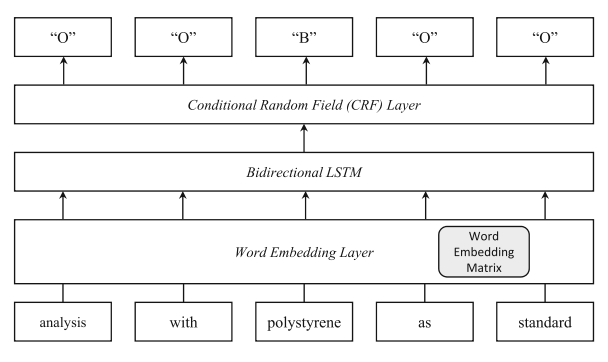

We can use Named Entity Recognition based approach as mentioned in the figure above. For this approach 1st step is to label our dataset using BIO scheme. You can read the <a href="https://link.springer.com/content/pdf/10.1007%2F978-3-030-50417-5_23.pdf">paper</a> to explore on the next steps.

Also, thanks to @nbroad for pointing out bugs in the code